In [2]:
# Importar librerías
import pandas as pd

# Cargar datos desde el Excel original
df = pd.read_excel('/content/Online Retail.xlsx')

# Explorar estructura
print("Shape inicial:", df.shape)
print("Columnas:", df.columns)
print(df.head())

# Filtrado general:
# - Eliminar facturas canceladas (InvoiceNo que contienen 'C')
df = df[~df['InvoiceNo'].astype(str).str.contains('C', na=False)]

# - Filtrar país: solo 'United Kingdom'
df = df[df['Country'] == 'United Kingdom']

# - Eliminar filas con Quantity <= 0 o UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

print("Shape después de limpieza:", df.shape)

# Crear columna 'TotalPrice' = Quantity * UnitPrice (opcional pero útil para validación)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Ver primeros registros después de limpieza
df.head()


Shape inicial: (541909, 8)
Columnas: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
Shape des

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
# 📅 Creamos columna YearMonth (ejemplo: 2010-12)
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# 🔗 Agrupamos por producto y mes
agg_df = df.groupby(['StockCode', 'YearMonth']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

agg_df.rename(columns={'Quantity': 'Cantidad', 'UnitPrice': 'PrecioMedio'}, inplace=True)

print("Shape del dataframe agregado:", agg_df.shape)
print(agg_df.head(10))


Shape del dataframe agregado: (33746, 4)
  StockCode YearMonth  Cantidad  PrecioMedio
0     10002   2010-12       143     1.255000
1     10002   2011-01       147     1.019286
2     10002   2011-02        51     1.110000
3     10002   2011-03        28     1.142500
4     10002   2011-04        69     0.850000
5     10080   2011-02         2     0.850000
6     10080   2011-06        60     0.390000
7     10080   2011-07        24     0.390000
8     10080   2011-08        60     0.390000
9     10080   2011-09        60     0.390000


In [4]:
# 1️⃣ Calculamos desviación estándar de precio para cada StockCode
precio_var_df = agg_df.groupby('StockCode')['PrecioMedio'].std().reset_index()
precio_var_df.rename(columns={'PrecioMedio': 'PrecioStd'}, inplace=True)

# 2️⃣ Unimos para agregar esta métrica al dataframe principal
agg_df = agg_df.merge(precio_var_df, on='StockCode', how='left')

# 3️⃣ Filtramos: solo productos con cierta variabilidad de precio
umbral_std = 0.01  # umbral arbitrario pero razonable
agg_df_filtrado = agg_df[agg_df['PrecioStd'] > umbral_std]

print(f"Observaciones tras filtrar productos con precio variable: {agg_df_filtrado.shape[0]}")
print(f"Productos únicos seleccionados: {agg_df_filtrado['StockCode'].nunique()}")


Observaciones tras filtrar productos con precio variable: 31427
Productos únicos seleccionados: 3283


In [5]:
import numpy as np
import statsmodels.api as sm

# 1️⃣ Transformación logarítmica
agg_df_filtrado['log_Cantidad'] = np.log(agg_df_filtrado['Cantidad'])
agg_df_filtrado['log_Precio'] = np.log(agg_df_filtrado['PrecioMedio'])

# 2️⃣ Variables dependiente e independiente
X = agg_df_filtrado[['log_Precio']]
X = sm.add_constant(X)  # añadir intercepto
y = agg_df_filtrado['log_Cantidad']

# 3️⃣ Ajuste del modelo OLS
modelo = sm.OLS(y, X).fit()

# 4️⃣ Resultados
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:           log_Cantidad   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     3675.
Date:                Mon, 21 Jul 2025   Prob (F-statistic):               0.00
Time:                        07:34:56   Log-Likelihood:                -62581.
No. Observations:               31427   AIC:                         1.252e+05
Df Residuals:                   31425   BIC:                         1.252e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9823      0.013    295.080      0.0

/tmp/ipython-input-5-2951859887.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_filtrado['log_Cantidad'] = np.log(agg_df_filtrado['Cantidad'])
/tmp/ipython-input-5-2951859887.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_filtrado['log_Precio'] = np.log(agg_df_filtrado['PrecioMedio'])


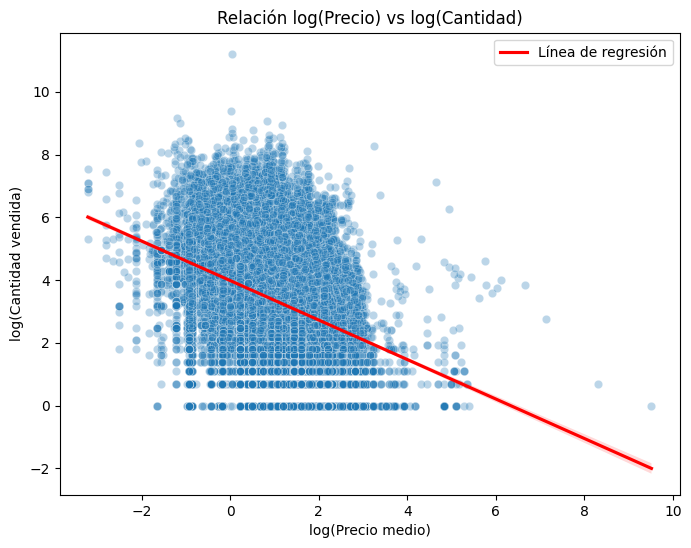

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x='log_Precio', y='log_Cantidad', data=agg_df_filtrado, alpha=0.3)
sns.regplot(x='log_Precio', y='log_Cantidad', data=agg_df_filtrado,
            scatter=False, color='red', label='Línea de regresión')

plt.title('Relación log(Precio) vs log(Cantidad)')
plt.xlabel('log(Precio medio)')
plt.ylabel('log(Cantidad vendida)')
plt.legend()
plt.show()


### 📋 Conclusiones del análisis

- Hemos estimado un modelo de elasticidad precio-demanda aplicando una regresión log-log sobre datos reales del dataset *Online Retail* (UCI).

- El coeficiente estimado para `log(Precio)` ha sido:
  \[
  \beta_1 = -0.6292
  \]
  **Interpretación**:
  > Por término medio, un incremento del 1% en el precio está asociado con una disminución del 0,63% en la cantidad vendida.  
  > Esto refleja una **elasticidad precio-demanda inelástica** (magnitud < 1), lo que sugiere que la demanda en este conjunto de productos es relativamente poco sensible al precio.

- El signo negativo del coeficiente es coherente con la teoría económica (ley de la demanda: relación inversa entre precio y cantidad demandada).

- El modelo presenta un R² ≈ 0,105, lo que indica que el precio explica aproximadamente el 10,5% de la variabilidad en la demanda agregada de estos productos.  
  Este valor es razonable dado que **existen otros factores relevantes que afectan la demanda** y que no han sido incluidos en este modelo básico (por ejemplo: promociones, estacionalidad, características de producto, competencia, etc.).

- El coeficiente estimado es estadísticamente significativo (p-valor < 0,001), lo que respalda la existencia de una relación negativa entre precio y demanda en estos datos.

---

**Conclusión general**:
> Este análisis proporciona una cuantificación robusta y coherente de la elasticidad precio-demanda en el contexto de ventas online.  
> Permite a empresas del sector comprender mejor cómo cambios de precio afectan las ventas, ayudando a informar decisiones estratégicas de pricing.

